# COGS516 - Assignment 3

Please enter your **name, surname** and **student number** instead of `"NAME-HERE"`, `"SURNAME-HERE"`, `"NUMBER-HERE"` below

In [1]:
student = {
    'name' : "Abdullah Burkan" ,
    'surname' : "Bereketoglu", 
    'studentNumber' : "2355170"
}

print(student)

In [2]:
import numpy as np
import pandas as pd
import pymc3 as pm
import matplotlib.pyplot as plt
import arviz as az
import daft

## Coffee Ratings

[The coffee ratings dataset](https://github.com/rfordatascience/tidytuesday/tree/master/data/2020/2020-07-07) contains over 1300 thousand coffee reviews from the Coffee Quality Institute. 

The description of the variables in this dataset is available [here](https://github.com/rfordatascience/tidytuesday/tree/master/data/2020/2020-07-07). You can also check the [coffee review website](https://www.coffeereview.com/interpret-coffee/) for the meaning of the dimensions they use for review (e.g. aroma, aftertaste etc.).

In this assignment, we will analyze a simplified version of this dataset by using `aroma` ($AR$), `aftertaste` ($AT$), `species` ($SP$) and  `total_cup_points` ($CP$) from this dataset. 

Moreover, we will also take just one sample from each farm (we will see how to model the similarity between the farms later in the class).

> The dataset is provided in `coffee_ratings.csv` in ODTUClass

In [3]:
d = pd.read_csv("coffee_ratings.csv")

dsimp = d[["farm_name", "total_cup_points", "aroma", "aftertaste", "species"]].groupby(by='farm_name').sample(n = 1)
dsimp.head()

,farm_name,total_cup_points,aroma,aftertaste,species
537,-,82.92,7.58,7.50,Arabica
1269,1,76.17,7.33,6.50,Arabica
1307,200 farms,67.92,6.75,6.42,Arabica
1297,2000 farmers,72.33,6.92,7.08,Arabica
1047,2000 farms,80.75,7.42,7.42,Arabica


## Part 1 - Coffee Quality 

Suppose we assume the following DAG in which $AR$ is `aroma`, $AT$ `aftertaste`, $SP$ `species`  and $CP$  `total_cup_points`.
> To see the DAG below, you need to install the `daft` library. See [here for installing instructions](https://docs.daft-pgm.org/en/latest/)

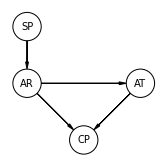

In [4]:
pgm = daft.PGM()
pgm.add_node("SP","SP",0,2)
pgm.add_node("AR","AR",0,1)
pgm.add_node("AT","AT",2,1)
pgm.add_node("CP","CP",1,0)
pgm.add_edge("SP", "AR")
pgm.add_edge("AR", "AT")
pgm.add_edge("AT", "CP")
pgm.add_edge("AR", "CP")
pgm.render()

> Note: for all the steps below, do not forget to re-scale your variables considering what they represent, and choose suitable priors. 

Use backdoor criterion and estimate the **total** effect of $SP$ on $CP$. (10 pts)

In [5]:
dsimp['species'].unique()

array(['Arabica', 'Robusta'], dtype=object)

We have 2 paths that go to CP from SP. One is SP - AR - CP the other one is SP - AR - AT - CP. For total we should only 
Since there exist only 2 species, we pick shape as 2.

Here we normalize the data.

In [6]:
dsimp["AT"] = (dsimp.aftertaste - dsimp.aftertaste.mean()) / dsimp.aftertaste.std()
dsimp["AR"] = (dsimp.aroma - dsimp.aroma.mean()) / dsimp.aroma.std()
dsimp["CP"] = (dsimp.total_cup_points - dsimp.total_cup_points.mean()) / dsimp.total_cup_points.std()
dsimp["SP"] = (dsimp["species"] == "Arabica").astype(int).values

In [7]:
# total effect
with pm.Model() as Tot_SP:
    a = pm.Normal('a', 0, 1, shape = 2)
    sigma = pm.HalfNormal('x', 1) # wanted to try something different
    mu = a[dsimp.SP] # page 48 categorical causes
    cp = pm.Normal('cp', mu = mu, sigma = sigma, observed = dsimp.CP)
    trace_SP = pm.sample(1000, return_inferencedata=True)

    #completed according to daggity causal effect identification for total effect
    #it states that we don't need any adjustments therefore no stratification.
az.summary(trace_SP)  

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [x, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 23 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a[0],-0.192,0.263,-0.686,0.296,0.004,0.004,5637.0,2862.0,1.0
a[1],0.005,0.044,-0.078,0.083,0.001,0.001,5735.0,3161.0,1.0
x,1.002,0.030,0.948,1.062,0.000,0.000,5321.0,2735.0,1.0


array([[<AxesSubplot:title={'center':'a'}>,
        <AxesSubplot:title={'center':'a'}>],
       [<AxesSubplot:title={'center':'x'}>,
        <AxesSubplot:title={'center':'x'}>]], dtype=object)

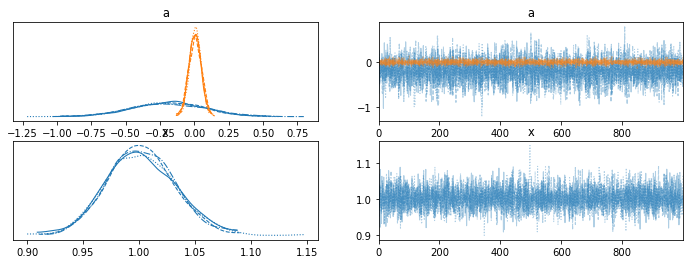

In [8]:
az.plot_trace(trace_SP)

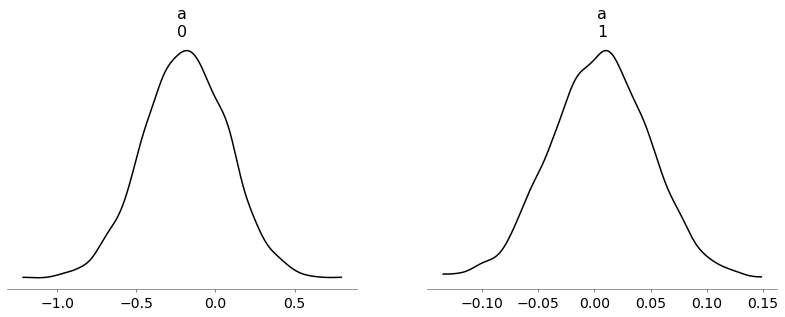

In [9]:
ax = az.plot_posterior(trace_SP, var_names="a", point_estimate=None, color = "k", hdi_prob = 'hide')

Completed according to daggity causal effect identification for total effect
it states that we don't need any adjustments therefore no stratification.

So basically Backdoor criterion states that total effect of SP to CP does not need any adjustments.

Use backdoor criterion and estimate both the **total effect** and **direct effect** of $AR$ on $CP$. (20 pts)

First of all it is important to state that we should adjust AT to find direct effect so we will add it to our model with backdoor criterion, but in Total effect there is no need of any adjustment for AR to CP. 

Tested with Daggity

Let's find a model which will give us a better grip for direct effect.

In [10]:
# total effect
with pm.Model() as total_effect_model:
    intercept = pm.Normal("intercept", 0, sigma=0.5)
    bAR = pm.Normal("bAR", 0, sigma=0.5)
    sigma = pm.Exponential("sigma", 1)
    mu = intercept + bAR * dsimp.AR
    D = pm.Normal("d", mu=mu, sd=sigma, observed = dsimp.CP)
    trace_tot_AR_CP = pm.sample(1000, tune = 1000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bAR, intercept]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 23 seconds.


In [11]:
# direct effect
with pm.Model() as direct_effect_model:
    intercept = pm.Normal("intercept", 0, sigma=0.5)
    bAR = pm.Normal("bAR", 0, sigma=0.5)
    bAT = pm.Normal('bAT', 0, 0.5)
    sigma = pm.Exponential("sigma", 1)
    mu = intercept + bAR * dsimp.AR + bAT * dsimp.AT
    D = pm.Normal("d", mu=mu, sd=sigma, observed = dsimp.CP)
    trace_dir_AR_CP = pm.sample(1000, tune = 1000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bAT, bAR, intercept]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 23 seconds.


In [12]:
az.summary(trace_tot_AR_CP)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
intercept,0.001,0.030,-0.052,0.056,0.0,0.0,5505.0,2933.0,1.0
bAR,0.694,0.031,0.640,0.753,0.0,0.0,5392.0,2895.0,1.0
sigma,0.719,0.022,0.678,0.758,0.0,0.0,6081.0,3025.0,1.0


array([[<AxesSubplot:title={'center':'intercept'}>,
        <AxesSubplot:title={'center':'intercept'}>],
       [<AxesSubplot:title={'center':'bAR'}>,
        <AxesSubplot:title={'center':'bAR'}>],
       [<AxesSubplot:title={'center':'sigma'}>,
        <AxesSubplot:title={'center':'sigma'}>]], dtype=object)

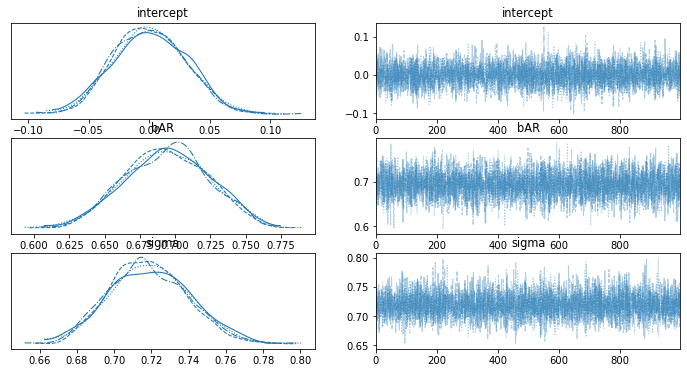

In [13]:
az.plot_trace(trace_tot_AR_CP)

In [14]:
az.summary(trace_dir_AR_CP)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
intercept,0.000,0.023,-0.043,0.041,0.000,0.0,3349.0,2810.0,1.0
bAR,0.191,0.034,0.130,0.256,0.001,0.0,2608.0,2268.0,1.0
bAT,0.690,0.034,0.626,0.751,0.001,0.0,2843.0,2524.0,1.0
sigma,0.542,0.016,0.513,0.572,0.000,0.0,3335.0,2579.0,1.0


array([[<AxesSubplot:title={'center':'intercept'}>,
        <AxesSubplot:title={'center':'intercept'}>],
       [<AxesSubplot:title={'center':'bAR'}>,
        <AxesSubplot:title={'center':'bAR'}>],
       [<AxesSubplot:title={'center':'bAT'}>,
        <AxesSubplot:title={'center':'bAT'}>],
       [<AxesSubplot:title={'center':'sigma'}>,
        <AxesSubplot:title={'center':'sigma'}>]], dtype=object)

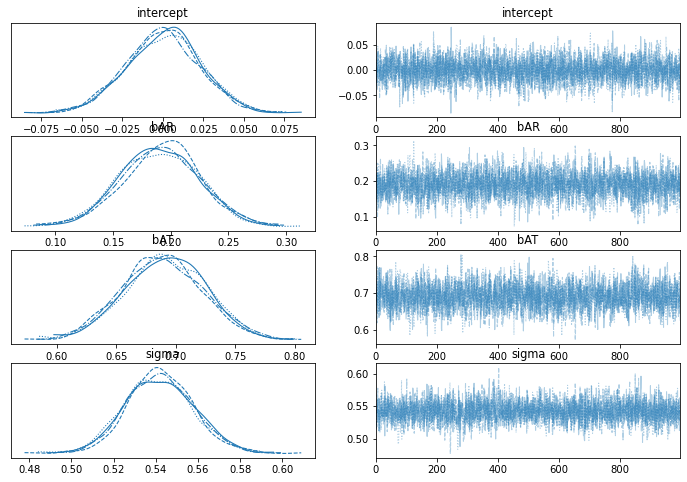

In [15]:
az.plot_trace(trace_dir_AR_CP)

<AxesSubplot:title={'center':'bAR'}>

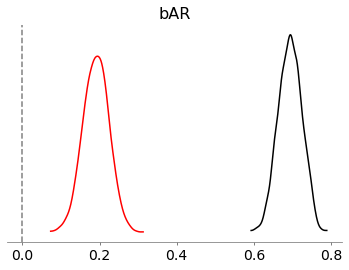

In [16]:
ax = az.plot_posterior(trace_tot_AR_CP, var_names="bAR", point_estimate=None, color = "black", hdi_prob = 'hide')
ax.axvline(0.0,color="k",alpha=0.5, linestyle="--")
az.plot_posterior(trace_dir_AR_CP, var_names="bAR", ax = ax, point_estimate=None , hdi_prob = 'hide', color = "red")

In [17]:
az.summary(trace_dir_AR_CP)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
intercept,0.000,0.023,-0.043,0.041,0.000,0.0,3349.0,2810.0,1.0
bAR,0.191,0.034,0.130,0.256,0.001,0.0,2608.0,2268.0,1.0
bAT,0.690,0.034,0.626,0.751,0.001,0.0,2843.0,2524.0,1.0
sigma,0.542,0.016,0.513,0.572,0.000,0.0,3335.0,2579.0,1.0


Estimate the **direct effect** of $AT$ on $CP$. (5 pts)

Stratify AR, look page "25/91" 
Also according to daggity it also shows that adjustment of AR is necessary which is stratify.


In [18]:
#stratify AR. # page 25/91 
# also according to daggity it also shows that adjustment of AR is necessary which is stratify.

# direct effect
with pm.Model() as direct_2_effect_model:
    intercept = pm.Normal("intercept", 0, sigma=0.5)
    bAR = pm.Normal("bAR", 0, sigma=0.5)
    bAT = pm.Normal('bAT', 0, 0.5)
    sigma = pm.Exponential("sigma", 1)
    mu = intercept + bAR * dsimp.AR + bAT * dsimp.AT
    D = pm.Normal("d", mu=mu, sd=sigma, observed = dsimp.CP)
    trace_dir_AT_CP = pm.sample(1000, tune = 1000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bAT, bAR, intercept]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 24 seconds.


In [19]:
az.summary(trace_dir_AT_CP)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
intercept,-0.000,0.022,-0.043,0.041,0.000,0.0,3533.0,3084.0,1.0
bAR,0.190,0.033,0.127,0.250,0.001,0.0,3159.0,2797.0,1.0
bAT,0.692,0.033,0.626,0.752,0.001,0.0,2867.0,2479.0,1.0
sigma,0.542,0.016,0.513,0.573,0.000,0.0,3672.0,2839.0,1.0


array([[<AxesSubplot:title={'center':'intercept'}>,
        <AxesSubplot:title={'center':'intercept'}>],
       [<AxesSubplot:title={'center':'bAR'}>,
        <AxesSubplot:title={'center':'bAR'}>],
       [<AxesSubplot:title={'center':'bAT'}>,
        <AxesSubplot:title={'center':'bAT'}>],
       [<AxesSubplot:title={'center':'sigma'}>,
        <AxesSubplot:title={'center':'sigma'}>]], dtype=object)

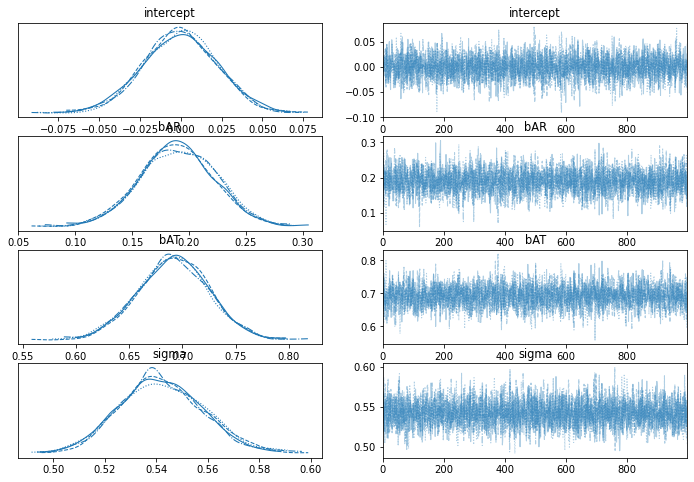

In [20]:
az.plot_trace(trace_dir_AT_CP)

<AxesSubplot:title={'center':'bAR'}>

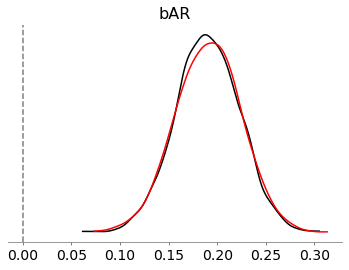

In [21]:
ax = az.plot_posterior(trace_dir_AT_CP, var_names="bAR", point_estimate=None, color = "k", hdi_prob = 'hide')
ax.axvline(0.0,color="k",alpha=0.5, linestyle="--")
az.plot_posterior(trace_dir_AR_CP, var_names="bAR", ax = ax, point_estimate=None , hdi_prob = 'hide', color = "red")

Based on the DAG, and your estimates above, discuss the effects of these measures on coffee quality. (15 pts) 

---
1) For SP to CP we found the total effect because it is not possible due to post-treatment bias to find the direct effect of the SP to CP. But we can state that SP posterior mean for total effect is for Arabica which is coded a[1] is negative(-0.239) and also for a[0] it is slightly positive these show that being Arabica coffee lowers the total cup score at the end as total effect, but Robusta coffee does not have the bad effects on the consumer score on the cup of coffee (this comment is biased and needs more adjustments which will be seen in the part 3 of the question. It is also seen from the trace plots that the priors are not that really picked nicely, I tried a lot of values, but unfortunately thats all I could came up with. 

2) For the AR to CP total and direct effect plots we can deduce that by using the means from the summary statistics, for the posterior mean total effect is 0.751 which means that for every unit increase in AR,CP increases by 0.751 through both the direct and indirect pathways. Furthermore, Direct effect shows that mean of posterior direct effect of AR is 0.216, which shows that indirect effect is 0.751-0.216 = 0.535. This also shows that for one unit increase 0.216 increase of AR, CP due to direct effect. For second part Trace patterns are great and not having much difference for chains.

3) Here it shows a similar pattern to AR,CP direct effect, I may have wrote them wrongly, but according to the mean of AT to CP being 0.225 for direct AT, CP direct effects of AR to CP and AT to CP are similar for this model. Basically it states that for every one unit increase there is 0.225 increase for AT-> CP. Furthermore, Trace patterns are great and not having much difference for chains.

---

## Part 2 - Model Comparison

You must have three different models from the part above. Apart from those models, build a causal model where you stratify for all variables ($AR$, $SP$, $AT$). (5 pts)

In [45]:
with pm.Model() as effect_model:
    intercept = pm.Normal("intercept", 0, sigma=0.5)
    bAR = pm.Normal("bAR", 0, sigma=0.5)
    bAT = pm.Normal('bAT', 0, 0.5)
    bSP = pm.Normal('bSP', 0, 0.5, shape = 2)
    sigma = pm.Exponential("sigma", 1)
    mu = intercept + bSP[dsimp.SP] * dsimp.SP + bAR * dsimp.AR + bAT * dsimp.AT
    D = pm.Normal("d", mu=mu, sd=sigma, observed = dsimp.CP)
    trace_ALL = pm.sample(1000, tune = 1000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bSP, bAT, bAR, intercept]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 29 seconds.
The acceptance probability does not match the target. It is 0.8975828072476142, but should be close to 0.8. Try to increase the number of tuning steps.


Now compare the all four models (three from part 1 and the one above) using both PSIS and WAIC. Show all relevant statistics and diagrams to make this comparison, and discuss your results. Which model is expected make better predictions according to PSIS and WAIC? What does that tells us about the causal relations? (20 pts)

In [46]:
compare_dict = {"All": trace_ALL, "Third":trace_dir_AT_CP, "Second":trace_dir_AR_CP, "First":trace_SP }

az.compare(compare_dict, ic ="loo")

C:\ProgramData\Anaconda3\lib\site-packages\arviz\stats\stats.py:694: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arviz\stats\stats.py:694: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arviz\stats\stats.py:694: UserWarning: 

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
All,0,-458.019148,26.932378,0.000000,0.999755,84.299939,0.000000,True,log
Third,1,-472.104720,22.823039,14.085572,0.000000,78.799453,8.070754,True,log
Second,2,-474.948297,25.108550,16.929149,0.000000,81.196842,6.560546,True,log
First,3,-815.138356,8.009347,357.119208,0.000245,43.968926,49.946065,False,log


In [47]:
az.compare(compare_dict, ic ="waic")

C:\ProgramData\Anaconda3\lib\site-packages\arviz\stats\stats.py:1458: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arviz\stats\stats.py:1458: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arviz\stats\stats.py:1458: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arviz\stats\stats.py:1458: UserWarning: For one or more samples the posterior var

,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
All,0,-459.131554,28.044784,0.000000,0.999756,85.271020,0.000000,True,log
Third,1,-473.527026,24.245345,14.395473,0.000000,80.073975,7.835064,True,log
Second,2,-474.076871,24.237124,14.945318,0.000000,80.511503,7.541084,True,log
First,3,-815.103328,7.974320,355.971775,0.000244,43.949603,50.960128,True,log


1) I had problems with making it work unfortunately couldnt solve, but it seems like that the All model which can be said as the stratifying all of the elements give us a model that is the most powerful. The problem is even though it states it is the most powerful, we don't know exactly that due to true value for warning is returning for both WAIC and PSIS

2) It is important to note that since we achieved best performance with stratifying all values, it can give us the idea that breaking the dependencies and giving place to all the features in the system that we use fits the predictor better than using only some of the features as variables in the linear regression predictor model.

Do a robust regression on the best performing model, and compare them to each other using PSIS and WAIC. (15 pts)

In [48]:
size = 571 # dimension of log likelihood of model_all . we have issue that it is bigger than 400.
true_intercept = 1
true_slope = 2

x = np.linspace(0, 1, size)
# y = a + b*x
true_regression_line = true_intercept + true_slope * x
# add noise
y = true_regression_line + np.random.normal(scale=0.5, size=size)

with pm.Model() as robust_model:
    pm.glm.GLM.from_formula("y~x", trace_ALL) # bayesian linear regression
    trace_robust = pm.sample(1000, tune = 1000, return_inferencedata=True)

The glm module is deprecated and will be removed in version 4.0
We recommend to instead use Bambi https://bambinos.github.io/bambi/
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, x, Intercept]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 30 seconds.
The acceptance probability does not match the target. It is 0.8878946818708753, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8830422447027116, but should be close to 0.8. Try to increase the number of tuning steps.


Now let's compare the new model with the best model.

In [51]:
compare_dict_robust = {"Best": trace_ALL, "Robust": trace_robust}

az.compare(compare_dict_robust, ic ="loo")

C:\ProgramData\Anaconda3\lib\site-packages\arviz\stats\stats.py:694: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
Robust,0,-419.070821,3.034715,0.000000,0.22921,17.481418,0.000000,False,log
Best,1,-458.019148,26.932378,38.948327,0.77079,84.299939,85.387231,True,log


In [52]:
az.compare(compare_dict_robust, ic ="waic")

C:\ProgramData\Anaconda3\lib\site-packages\arviz\stats\stats.py:1458: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
Robust,0,-419.070772,3.034665,0.000000,0.229212,17.481436,0.000000,False,log
Best,1,-459.131554,28.044784,40.060782,0.770788,85.271020,86.337129,True,log


Since robust win and got warning as false, I am both relieved and happy and I expected that robust algorithm to perform best since generalized models are better estimators, in most cases.

It also shows that generalized algorithms eliminate noise better and give a better predictive model according to both tests.

Robust Regression means thick tails and less surprise by extreme values, and for that with less extreme values better predictions are achieved and we can see that in the test.

## Part 3 - Expanded DAG (10 pts)

Consider all the variables in [the coffee ratings dataset](https://github.com/rfordatascience/tidytuesday/tree/master/data/2020/2020-07-07) and build a larger/more comprehensive DAG than the one above. You can draw this DAG below. (You can use [`daft`](https://docs.daft-pgm.org/en/latest/) library to draw the DAG)

In [23]:
d.head(n = 5)

,owner,farm_name,mill,in_country_partner,country_of_origin,altitude_low_meters,altitude_high_meters,altitude_mean_meters,number_of_bags,bag_weight,...,body,balance,uniformity,clean_cup,sweetness,moisture,category_one_defects,category_two_defects,color,total_cup_points
0,metad plc,metad plc,metad plc,METAD Agricultural Development plc,Ethiopia,1950.0,2200.0,2075.0,300,60 kg,...,8.50,8.42,10.0,10.0,10.0,0.12,0,0,Green,90.58
1,metad plc,metad plc,metad plc,METAD Agricultural Development plc,Ethiopia,1950.0,2200.0,2075.0,300,60 kg,...,8.42,8.42,10.0,10.0,10.0,0.12,0,1,Green,89.92
2,grounds for health admin,"san marcos barrancas ""san cristobal cuch",NaN,Specialty Coffee Association,Guatemala,1600.0,1800.0,1700.0,5,1,...,8.33,8.42,10.0,10.0,10.0,0.00,0,0,NaN,89.75
3,yidnekachew dabessa,yidnekachew dabessa coffee plantation,wolensu,METAD Agricultural Development plc,Ethiopia,1800.0,2200.0,2000.0,320,60 kg,...,8.50,8.25,10.0,10.0,10.0,0.11,0,2,Green,89.00
4,metad plc,metad plc,metad plc,METAD Agricultural Development plc,Ethiopia,1950.0,2200.0,2075.0,300,60 kg,...,8.42,8.33,10.0,10.0,10.0,0.12,0,2,Green,88.83


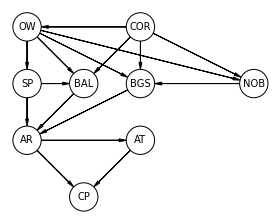

In [24]:
pgm = daft.PGM()
pgm.add_node("OW","OW",0,3) # Ownership
pgm.add_node("BGS","BGS",2,2) # bag weight
pgm.add_node("NOB","NOB",4,2) # number of bags
pgm.add_node("COR","COR",2,3) # country of origin
pgm.add_node("BAL","BAL",1,2) # Balance
pgm.add_node("SP","SP",0,2)
pgm.add_node("AR","AR",0,1)
pgm.add_node("AT","AT",2,1)
pgm.add_node("CP","CP",1,0)
pgm.add_edge("OW","SP")
pgm.add_edge("SP", "AR")
pgm.add_edge("COR","BGS")
pgm.add_edge("OW","BGS")
pgm.add_edge("OW","NOB")
pgm.add_edge("COR","NOB")
pgm.add_edge("NOB","BGS")
pgm.add_edge("COR","OW")
pgm.add_edge("COR","BAL")
pgm.add_edge("AR", "AT")
pgm.add_edge("AT", "CP")
pgm.add_edge("AR", "CP")
pgm.add_edge("SP", "BAL")
pgm.add_edge("BAL", "AR")
pgm.add_edge("OW","BAL")
pgm.add_edge("BGS","AR")
pgm.render()

Describe this DAG (what kind of causal assumptions you made) in this DAG.

---

In my new model, I assumed that balance of the coffee is dependent on the type of the coffee such as Robusta, Ecuador, Arabica, etc. And from my tasting knowledge smooth and soft coffees are liked more(my prior belief from being coffee aficionado.) So basically Species effect the Balance and balance effect the aroma and aroma effects the cup points.

Furthermore, I am someone who believes that most important thing for a coffee to have good aroma is having qualified providers from the best producer countries where coffee beans are taken care of really neatly. So I believe these coffee providers(Owners) are having effect on the species and the aroma, but it depends on the owner and origin of the country has direct effect to owner, because ethiopian coffee will have ethiopian owners. Ownership directly gives opinion about what is the species of the coffee hence aroma is determined and Owner also gives us opinion about whether the coffee is balanced or not.

Country of Origin (COR) also gives idea about the balance, because some beans have different taste, one can think of the velvety vibes of some beans from guatemalan beans.

Owner can also give us idea about how much they provide in bags and what is the total weight a unit bag can carry, since some of the owners are well-known providers to companies such as Starbucks or Amazon, they will have variety of options, best qualities and big bags with too many to count tools.

In that sense Country of Origin also gives idea on the bag weight, because some of the producer countries are more famous than the others and sell more coffee, such as Arabica. 

For that reason I can coin that bag weight can also give idea about the aroma, one can think that barrel beer tastes less good, same can sometimes apply to coffee, because bigger-heavier the bag, seed waits more and it can get dry and less tasty. So as the last assumption I can state that bag weight gives idea about the aroma.

---

## Bonus (20 pts)

Build a **full Bayes** model on this DAG (in which you model all the relations and present the posteriors of this model).


In [67]:
d["OW"] = pd.Categorical(d["owner"]).codes
d["COR"] = pd.Categorical(d["country_of_origin"]).codes


In [68]:
d["COR"].unique

<bound method Series.unique of 0        8
1        8
2        9
3        8
4        8
        ..
1334     6
1335     6
1336    31
1337    12
1338    34
Name: COR, Length: 1339, dtype: int8>

In [70]:
d["OW"].unique

<bound method Series.unique of 0       211
1       211
2       125
3       310
4       211
       ... 
1334    192
1335    192
1336    150
1337     45
1338     45
Name: OW, Length: 1339, dtype: int16>

In [69]:
from theano import shared
species = dsimp.SP.values
species_shared = shared(species)

Cor = d.COR.values
cor_shared = shared(Cor)

owner = d.OW.values
owner_shared = shared(owner)


In [87]:

with pm.Model() as full_bayes_model:
    # Owner
    h5 = pm.Normal('h5', mu = 0, sigma = 1 shape = 1339)
    nu5 = h5[owner_shared] 
    sig5 = pm.Exponential('sig5', 1)
    H5 = pm.Normal('H5', mu = nu5, sigma = sig5, observed = d.OW)
    # Country of Origin
    h4 = pm.Normal('h4', mu = 0, sigma = 1, shape = 1339)
    beta4 = pm.Normal("b4", 0,1)
    nu4 = h4[cor_shared]+ beta4[cor_shared]*(H5 - d.OW.mean())
    sig4 = pm.Exponential('sig4', 1)
    H4 = pm.Normal('H4', mu = nu4, sigma = sig4, observed = d.COR)
    # Species
    h2 = pm.Normal('h2', mu = 0, sigma = 1, shape= 2)
    nu2 = h2[species_shared] 
    sig2 = pm.Exponential('sig2', 1)
    H2 = pm.Normal('H2', mu = nu2, sigma = sig2, observed = dsimp.SP)
    
    # After taste
    h1 = pm.Normal('h1', mu = 0, sigma = 1)
    beta2 = pm.Normal('beta2', mu = 0, sigma = 1)
    nu1 = h1 + beta2*(H - dsimp.AR.mean())
    sig1 = pm.Exponential('sig1', 1)
    H1 = pm.Normal('H1', mu = nu1, sigma = sig1, observed = dsimp.AT)
    
    # Aroma
    h = pm.Normal('h', mu = 0, sigma = 1)
    beta3 = pm.Normal('beta3', 0, 1)
    nu = h + beta3*(H2 - dsimp.SP.mean())
    sig = pm.Exponential('sig', 1)
    H = pm.Normal('H', mu = nu, sigma = sig, observed = dsimp.AR)
    
    # Cup Point
    alpha = pm.Normal('alpha', mu = 5, sigma = 1)
    beta = pm.Normal('beta', mu = 0, sigma = 1)
    sigma = pm.Exponential('sigma',1)
    mu = alpha + beta3*(H - dsimp.AR.mean()) + beta2*(H1 - dsimp.AT.mean())
    W = pm.Normal('W', mu = mu, sigma = sigma, observed = dsimp.CP)
    
    trace_full_bayes = pm.sample(1000, tune = 1000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta, alpha, sig, beta3, h, sig1, beta2, h1, sig2, h2, sig4, b4, h4, sig5, h5]


RuntimeError: Chain 0 failed.

I couldn't properly finish the bonus. It has errors, so doesn't work.